In [1]:

%pprint

Pretty printing has been turned OFF



## Let's use our labeled data to evaluate a Logistic Regression model

In [2]:

%%time
%run ../py/html_analysis.py

lr = LrUtilities()

C:\Users\dev\Documents\Repositories\job-hunting\jh\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dev\Documents\Repositories\job-hunting\jh\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dev\Documents\Repositories\job-hunting\jh\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dev\Documents\Repositories\job-hunting\jh\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Wall time: 1min 36s


In [3]:

sent_str = '<b>SQL experience</b>'
lr.lr_predict_single(sent_str)

'O-RQ'

In [4]:

sent_str = 'You work here.'
lr.lr_predict_single(sent_str)

'O-CS'

In [5]:

[f'lr.{fn}' for fn in dir(lr) if not fn.startswith('_')]

['lr.CV', 'lr.LR_DICT', 'lr.PREDICT_PERCENT_FIT_DICT', 'lr.TT', 'lr.build_lr_predict_percent', 'lr.build_lr_predict_percent_is_header', 'lr.conn', 'lr.cursor', 'lr.ha', 'lr.hc', 'lr.lr_predict_single', 'lr.su']

In [6]:

import random

print('\nCV')
print(lr.CV)
print('\nLR_DICT')
for k, v in random.sample(lr.LR_DICT.items(), 2):
    print(k, v)
print('\nPREDICT_PERCENT_FIT_DICT')
for k, v in random.sample(lr.PREDICT_PERCENT_FIT_DICT.items(), 2):
    print(k, v)
print('\nTT')
print(lr.TT)


CV
CountVectorizer(lowercase=False, min_df=0.0, ngram_range=(1, 5),
                strip_accents='ascii',
                tokenizer=<bound method HeaderAnalysis.html_regex_tokenizer of <__main__.HeaderAnalysis object at 0x00000217DBAACDC8>>)

LR_DICT
O-RQ LogisticRegression(C=375.0, class_weight='balanced', max_iter=1000,
                   penalty='l1', solver='liblinear', verbose=False)
H-SP LogisticRegression(C=375.0, class_weight='balanced', max_iter=1000,
                   penalty='l1', solver='liblinear', verbose=False)

PREDICT_PERCENT_FIT_DICT
O-TS <function LrUtilities.build_lr_predict_percent.<locals>.predict_percent_fit at 0x00000217E229B708>
H-O <function LrUtilities.build_lr_predict_percent.<locals>.predict_percent_fit at 0x00000217E229B048>

TT
TfidfTransformer(norm='l1')



## Test its accuracy

In [26]:

sql_str = f'''
    SELECT
        np.[navigable_parent],
        pos.[pos_symbol]
    FROM
        [Jobhunting].[dbo].[NavigableParents] np INNER JOIN
        [Jobhunting].[dbo].[PartsOfSpeech] pos ON
            pos.[is_header] = np.[is_header] AND
            pos.[is_task_scope] = np.[is_task_scope] AND
            pos.[is_minimum_qualification] = np.[is_minimum_qualification] AND
            pos.[is_preferred_qualification] = np.[is_preferred_qualification] AND
            pos.[is_legal_notification] = np.[is_legal_notification] AND
            pos.[is_job_title] = np.[is_job_title] AND
            pos.[is_office_location] = np.[is_office_location] AND
            pos.[is_job_duration] = np.[is_job_duration] AND
            pos.[is_supplemental_pay] = np.[is_supplemental_pay] AND
            pos.[is_educational_requirement] = np.[is_educational_requirement] AND
            pos.[is_interview_procedure] = np.[is_interview_procedure] AND
            pos.[is_corporate_scope] = np.[is_corporate_scope] AND
            pos.[is_posting_date] = np.[is_posting_date] AND
            pos.[is_other] = np.[is_other];'''
pos_df = pd.DataFrame(lr.su.get_execution_results(lr.cursor, sql_str, verbose=False))
POS_DICT = pos_df.set_index('navigable_parent')['pos_symbol'].to_dict()

In [36]:

y_true = []
y_pred = []
for sent_str, pos_symbol in POS_DICT.items():
    y_true.append(pos_symbol)
    y_pred.append(lr.lr_predict_single(sent_str))

In [38]:

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        H-CS       1.00      0.10      0.17        21
        H-ER       0.00      0.00      0.00         4
        H-IP       0.00      0.00      0.00         3
        H-JD       0.00      0.00      0.00         8
        H-JT       0.00      0.00      0.00         3
        H-LN       0.00      0.00      0.00         8
         H-O       0.00      0.00      0.00         4
        H-OL       1.00      0.05      0.10        20
        H-PD       0.00      0.00      0.00         2
        H-PQ       0.00      0.00      0.00        20
        H-RQ       0.71      0.08      0.15        61
        H-SP       0.00      0.00      0.00         9
        H-TS       0.98      0.60      0.74        67
        O-CS       0.52      0.92      0.67        13
        O-ER       0.75      0.50      0.60         6
        O-IP       0.43      0.60      0.50         5
        O-LN       0.27      1.00      0.42         8
         O-O       0.00    

C:\Users\dev\Documents\Repositories\job-hunting\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:

seen = set()
seen_add = seen.add
label_list = [x for x in y_true if not (x in seen or seen_add(x))]

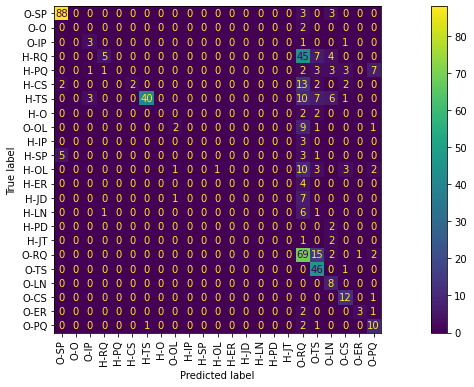

In [62]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=label_list)
fig, ax = plt.subplots(figsize=(18, 6))
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
xticklabels_list = ax.set_xticklabels(label_list, rotation='vertical')
yticklabels_list = ax.set_yticklabels(label_list)